In [1]:
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cooler
import cooltools.lib.plotting
from cooltools import insulation
import cooltools
import seaborn as sns
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe
from pybedtools import BedTool as pbt
import bbi
from tqdm import tqdm
from adjustText import adjust_text
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
from dotenv import load_dotenv
assert os.environ['CONDA_DEFAULT_ENV'] == "cultures_hic"

In [6]:
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Helvetica'
mpl.rc('lines', linewidth=0.4)
mpl.rc('font', family='Helvetica', size=8)
mpl.rc('axes', labelsize=8, titlesize=8, linewidth=0.4)
mpl.rc('legend', fontsize=8)
mpl.rc('xtick', labelsize=6)
mpl.rc('xtick.major', width=0.4, size=2)
mpl.rc('xtick.minor', width=0.4, size=1)
mpl.rc('ytick', labelsize=6)
mpl.rc('ytick.major', width=0.4, size=2)
mpl.rc('ytick.minor', width=0.4, size=1)

In [54]:
load_dotenv()
path_to_maps = os.getenv('PATH_TO_MAPS')
path_to_save = os.getenv('PATH_TO_SAVE_TAD_BORDERS')
path_to_save_pca_data = os.getenv('PATH_TO_SAVE_TAD_PCA_DATA')
path_to_save_visualizations = os.getenv('PATH_TO_TADS_VISUALIZATIONS')
resolution = 15_000
resolution_kb = 15 
window = 150
number_of_files = 23

In [8]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


## 1. TAD borders calling

In [15]:
def get_full_insulation_table_and_borders(file, path_to_maps, resolution, window, path_to_save =path_to_save, development=False):
    """
    Calculate the full insulation table and TAD boundaries for a given Hi-C map.

    Parameters:
    - file (str): The name of the Hi-C map file.
    - path_to_maps (str): The directory path where the Hi-C map files are stored.
    - resolution (int): The resolution of the Hi-C map in base pairs.
    - window (int): The window size for calculating insulation scores.
    - path_to_save (str): The directory path where the output files will be saved.
    - development (bool): Flag to indicate development mode for naming conventions.

    Returns:
    - insulation_table (DataFrame): The full insulation table.
    - boundaries (DataFrame): The TAD boundaries.
    """
    try:
        if not os.path.isfile(os.path.join(path_to_maps, file)):
            raise FileNotFoundError(f"The file {file} does not exist in the specified path {path_to_maps}.")
        
        if not os.path.isdir(path_to_save):
            os.makedirs(path_to_save)
            logging.info(f"Created directory: {path_to_save}")

        clr_path = f'{path_to_maps}/{file}::/resolutions/{resolution}'
        clr = cooler.Cooler(clr_path)

        window_sc = int(f'{window}000')
        insulation_table = insulation(clr, [window_sc], min_frac_valid_pixels=0.75, min_dist_bad_bin=4, verbose=False)

        resolution_kb = str(resolution // 1000)
        name = "_".join(file.split('.')[:3]) if development else file.split('.')[0]

        insulation_csv_path = os.path.join(path_to_save, f"full_insulation_score_{name}_{resolution_kb}res_{window}wind.csv")
        insulation_table.to_csv(insulation_csv_path, index=False)
        logging.info(f"Insulation table saved to {insulation_csv_path}")

        boundaries = insulation_table[
            ~insulation_table[f"log2_insulation_score_{window}000"].isna() &
            (insulation_table[f"is_boundary_{window}000"] == True)
        ][["chrom", 'start', 'end', f"log2_insulation_score_{window}000", f"boundary_strength_{window}000"]]

        boundaries_bed_path = os.path.join(path_to_save, f"tad_borders_{name}_{resolution_kb}res_{window}wind.bed")
        boundaries.to_csv(boundaries_bed_path, sep="\t", header=None, index=False)
        logging.info(f"TAD boundaries saved to {boundaries_bed_path}")

        return insulation_table, boundaries

    except Exception as e:
        logging.error(f"An error occurred: {e}")
        raise

In [16]:
files = [f for f in listdir(path_to_maps) if ".mcool" in f ]
assert len(files) == number_of_files
for file in tqdm(files):
    print(file)
    for resolution in [15_000]:
        print(resolution)
        for window in [150]:
            print(window)
            is_scores, borders = get_full_insulation_table_and_borders(file, path_to_maps, resolution, window, development=True)   

  0%|                                                                                                                                                                            | 0/23 [00:00<?, ?it/s]

Ballerino2022_NES_5kb.drop_diag.5kb.mcool.sampled_exact.mcool
15000
150


INFO:root:Insulation table saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/full_insulation_score_Ballerino2022_NES_5kb_drop_diag_5kb_15res_150wind.csv
INFO:root:TAD boundaries saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/tad_borders_Ballerino2022_NES_5kb_drop_diag_5kb_15res_150wind.bed
  4%|███████▏                                                                                                                                                            | 1/23 [00:18<06:50, 18.64s/it]

Lu2020_iPSC_NeuNplus.sampled_exact.mcool
15000
150


INFO:root:Insulation table saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/full_insulation_score_Lu2020_iPSC_NeuNplus_sampled_exact_mcool_15res_150wind.csv
INFO:root:TAD boundaries saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/tad_borders_Lu2020_iPSC_NeuNplus_sampled_exact_mcool_15res_150wind.bed
  9%|██████████████▎                                                                                                                                                     | 2/23 [00:45<08:10, 23.36s/it]

Rahman2023_FetalBrain.drop_diag.5kb.mcool.sampled_exact.mcool
15000
150


INFO:root:Insulation table saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/full_insulation_score_Rahman2023_FetalBrain_drop_diag_5kb_15res_150wind.csv
INFO:root:TAD boundaries saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/tad_borders_Rahman2023_FetalBrain_drop_diag_5kb_15res_150wind.bed
 13%|█████████████████████▍                                                                                                                                              | 3/23 [01:13<08:33, 25.70s/it]

Zaghi2023_iPSC_NeuNplus.sampled_exact.mcool
15000
150


INFO:root:Insulation table saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/full_insulation_score_Zaghi2023_iPSC_NeuNplus_sampled_exact_mcool_15res_150wind.csv
INFO:root:TAD boundaries saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/tad_borders_Zaghi2023_iPSC_NeuNplus_sampled_exact_mcool_15res_150wind.bed
 17%|████████████████████████████▌                                                                                                                                       | 4/23 [01:32<07:12, 22.76s/it]

Hu2021_NeuNplus.sampled_exact.mcool
15000
150


INFO:root:Insulation table saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/full_insulation_score_Hu2021_NeuNplus_sampled_exact_mcool_15res_150wind.csv
INFO:root:TAD boundaries saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/tad_borders_Hu2021_NeuNplus_sampled_exact_mcool_15res_150wind.bed
 22%|███████████████████████████████████▋                                                                                                                                | 5/23 [01:53<06:43, 22.39s/it]

Ballerino2022_iPSC_NeuNplus.sampled_exact.mcool
15000
150


INFO:root:Insulation table saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/full_insulation_score_Ballerino2022_iPSC_NeuNplus_sampled_exact_mcool_15res_150wind.csv
INFO:root:TAD boundaries saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/tad_borders_Ballerino2022_iPSC_NeuNplus_sampled_exact_mcool_15res_150wind.bed
 26%|██████████████████████████████████████████▊                                                                                                                         | 6/23 [02:13<06:06, 21.53s/it]

Rahman2023_NeuNplus.sampled_exact.mcool
15000
150


INFO:root:Insulation table saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/full_insulation_score_Rahman2023_NeuNplus_sampled_exact_mcool_15res_150wind.csv
INFO:root:TAD boundaries saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/tad_borders_Rahman2023_NeuNplus_sampled_exact_mcool_15res_150wind.bed
 30%|█████████████████████████████████████████████████▉                                                                                                                  | 7/23 [02:40<06:13, 23.37s/it]

Lu2020_iPSC_5kb.drop_diag.5kb.mcool.sampled_exact.mcool
15000
150


INFO:root:Insulation table saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/full_insulation_score_Lu2020_iPSC_5kb_drop_diag_5kb_15res_150wind.csv
INFO:root:TAD boundaries saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/tad_borders_Lu2020_iPSC_5kb_drop_diag_5kb_15res_150wind.bed
 35%|█████████████████████████████████████████████████████████                                                                                                           | 8/23 [03:04<05:53, 23.56s/it]

Our_data_iPSC_NeuNplus.drop_diag.5kb.mcool.sampled_exact.mcool
15000
150


INFO:root:Insulation table saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/full_insulation_score_Our_data_iPSC_NeuNplus_drop_diag_5kb_15res_150wind.csv
INFO:root:TAD boundaries saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/tad_borders_Our_data_iPSC_NeuNplus_drop_diag_5kb_15res_150wind.bed
 39%|████████████████████████████████████████████████████████████████▏                                                                                                   | 9/23 [03:26<05:19, 22.85s/it]

Heffel_infant.3056_cells.5kb.drop_diag.5kb.sampled_exact.mcool
15000
150


INFO:root:Insulation table saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/full_insulation_score_Heffel_infant_3056_cells_5kb_15res_150wind.csv
INFO:root:TAD boundaries saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/tad_borders_Heffel_infant_3056_cells_5kb_15res_150wind.bed
 43%|██████████████████████████████████████████████████████████████████████▊                                                                                            | 10/23 [03:48<04:56, 22.80s/it]

Wu2021_iPSC_NeuNplus.sampled_exact.mcool
15000
150


INFO:root:Insulation table saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/full_insulation_score_Wu2021_iPSC_NeuNplus_sampled_exact_mcool_15res_150wind.csv
INFO:root:TAD boundaries saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/tad_borders_Wu2021_iPSC_NeuNplus_sampled_exact_mcool_15res_150wind.bed
 48%|█████████████████████████████████████████████████████████████████████████████▉                                                                                     | 11/23 [04:11<04:33, 22.78s/it]

Tian2023_NeuNplus.EN_IN.29_42_58_years.2000_cells.sampled_exact.mcool
15000
150


INFO:root:Insulation table saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/full_insulation_score_Tian2023_NeuNplus_EN_IN_29_42_58_years_15res_150wind.csv
INFO:root:TAD boundaries saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/tad_borders_Tian2023_NeuNplus_EN_IN_29_42_58_years_15res_150wind.bed
 52%|█████████████████████████████████████████████████████████████████████████████████████                                                                              | 12/23 [04:34<04:12, 22.97s/it]

Ballerino2022_NPC_5kb.drop_diag.5kb.mcool.sampled_exact.mcool
15000
150


INFO:root:Insulation table saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/full_insulation_score_Ballerino2022_NPC_5kb_drop_diag_5kb_15res_150wind.csv
INFO:root:TAD boundaries saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/tad_borders_Ballerino2022_NPC_5kb_drop_diag_5kb_15res_150wind.bed
 57%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 13/23 [04:54<03:39, 21.90s/it]

Heffel_3T.3056_cells.5kb.drop_diag.5kb.sampled_exact.mcool
15000
150


INFO:root:Insulation table saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/full_insulation_score_Heffel_3T_3056_cells_5kb_15res_150wind.csv
INFO:root:TAD boundaries saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/tad_borders_Heffel_3T_3056_cells_5kb_15res_150wind.bed
 61%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 14/23 [05:19<03:26, 22.91s/it]

Heffel_2T.3056_cells.5kb.drop_diag.5kb.sampled_exact.mcool
15000
150


INFO:root:Insulation table saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/full_insulation_score_Heffel_2T_3056_cells_5kb_15res_150wind.csv
INFO:root:TAD boundaries saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/tad_borders_Heffel_2T_3056_cells_5kb_15res_150wind.bed
 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 15/23 [05:44<03:08, 23.60s/it]

Rajarajan_iPSC_NeuNplus.sampled_exact.mcool
15000
150


INFO:root:Insulation table saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/full_insulation_score_Rajarajan_iPSC_NeuNplus_sampled_exact_mcool_15res_150wind.csv
INFO:root:TAD boundaries saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/tad_borders_Rajarajan_iPSC_NeuNplus_sampled_exact_mcool_15res_150wind.bed
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 16/23 [06:08<02:45, 23.70s/it]

Pletenev2024_NeuNplus.sampled_exact.mcool
15000
150


INFO:root:Insulation table saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/full_insulation_score_Pletenev2024_NeuNplus_sampled_exact_mcool_15res_150wind.csv
INFO:root:TAD boundaries saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/tad_borders_Pletenev2024_NeuNplus_sampled_exact_mcool_15res_150wind.bed
 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 17/23 [06:31<02:21, 23.52s/it]

Rahman2023_iPSC_NeuNplus_CRISPRi_Scrambled_A_DpnII-HinfI.sampled_exact.mcool
15000
150


INFO:root:Insulation table saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/full_insulation_score_Rahman2023_iPSC_NeuNplus_CRISPRi_Scrambled_A_DpnII-HinfI_sampled_exact_mcool_15res_150wind.csv
INFO:root:TAD boundaries saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/tad_borders_Rahman2023_iPSC_NeuNplus_CRISPRi_Scrambled_A_DpnII-HinfI_sampled_exact_mcool_15res_150wind.bed
 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 18/23 [06:57<02:01, 24.28s/it]

Rajarajan_iPSC_Glia_5kb.drop_diag.5kb.mcool.sampled_exact.mcool
15000
150


INFO:root:Insulation table saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/full_insulation_score_Rajarajan_iPSC_Glia_5kb_drop_diag_5kb_15res_150wind.csv
INFO:root:TAD boundaries saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/tad_borders_Rajarajan_iPSC_Glia_5kb_drop_diag_5kb_15res_150wind.bed
 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 19/23 [07:20<01:35, 23.91s/it]

Rajarajan_NPC_5kb.drop_diag.5kb.mcool.sampled_exact.mcool
15000
150


INFO:root:Insulation table saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/full_insulation_score_Rajarajan_NPC_5kb_drop_diag_5kb_15res_150wind.csv
INFO:root:TAD boundaries saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/tad_borders_Rajarajan_NPC_5kb_drop_diag_5kb_15res_150wind.bed
 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 20/23 [07:42<01:09, 23.19s/it]

Li2022_iPSC_NeuNplus.sampled_exact.mcool
15000
150


INFO:root:Insulation table saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/full_insulation_score_Li2022_iPSC_NeuNplus_sampled_exact_mcool_15res_150wind.csv
INFO:root:TAD boundaries saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/tad_borders_Li2022_iPSC_NeuNplus_sampled_exact_mcool_15res_150wind.bed
 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 21/23 [08:07<00:47, 23.90s/it]

Zaghi2023_NPC_5kb.drop_diag.5kb.mcool.sampled_exact.mcool
15000
150


INFO:root:Insulation table saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/full_insulation_score_Zaghi2023_NPC_5kb_drop_diag_5kb_15res_150wind.csv
INFO:root:TAD boundaries saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/tad_borders_Zaghi2023_NPC_5kb_drop_diag_5kb_15res_150wind.bed
 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 22/23 [08:27<00:22, 22.44s/it]

Heffel_adult.3056_cells.5kb.drop_diag.5kb.sampled_exact.mcool
15000
150


INFO:root:Insulation table saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/full_insulation_score_Heffel_adult_3056_cells_5kb_15res_150wind.csv
INFO:root:TAD boundaries saved to /tank/projects/diana_hic/cultures_vs_postmortem/cultures_code/2_tads/tad_borders_files/tad_borders_Heffel_adult_3056_cells_5kb_15res_150wind.bed
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [08:49<00:00, 23.01s/it]


In [49]:
path_to_save_visualizations

## 2. Visualize

### 2.1 Prepare a table for PCA

In [23]:
res = f"_{resolution_kb}res"
insulation_score_datasets = [f for f in listdir(path_to_save) if "full_insulation_score_" in f and f"{resolution_kb}res" in f and f'{window}wind' in f]
insulation_score_datasets.sort()
assert len(insulation_score_datasets) == number_of_files


In [30]:
def create_pca_table(insulation_score_datasets, path_to_tads, path_to_save_pca_data, res="_15res", save_name=None):
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)
    
    if not isinstance(insulation_score_datasets, list) or not insulation_score_datasets:
        logger.error("insulation_score_datasets must be a non-empty list.")
        raise ValueError("insulation_score_datasets must be a non-empty list.")
    
    if not os.path.exists(path_to_tads):
        logger.error(f"Path to maps does not exist: {path_to_tads}")
        raise FileNotFoundError(f"Path to maps does not exist: {path_to_tads}")
    
    if save_name and not isinstance(save_name, str):
        logger.error("save_name must be a string.")
        raise ValueError("save_name must be a string.")
    
    dfs = {}
    for file in tqdm(insulation_score_datasets, desc="Reading datasets"):
        try:
            name = file.split(res)[0].split('full_insulation_score_')[1]
            logger.info(f"Processing file: {name}")
            dfs[name] = pd.read_csv(os.path.join(path_to_tads, file), sep=",")
        except Exception as e:
            logger.error(f"Failed to read or process file {file}: {e}")
            continue
    
    df_res_final = pd.DataFrame()
    for name, df in dfs.items():
        try:
            split_df = df.set_index(['chrom', 'start', 'end'])[['log2_insulation_score_150000']]
            split_df.columns = [name]
            df_res_final = pd.concat([df_res_final, split_df], axis=1)
            logger.info(f"Data shape after concatenating {name}: {df_res_final.shape}")
        except KeyError as e:
            logger.error(f"Missing expected columns in {name}: {e}")
            continue
    
    df_res_final.dropna(inplace=True)
    df_res_final.reset_index(inplace=True)
    df_res_final = df_res_final[~df_res_final.chrom.isin(["chrX", "chrY", 'chrM'])]
    logger.info(f"Final data shape after dropping NA and unwanted chromosomes: {df_res_final.shape}")

    if save_name:
        save_path = os.path.join(path_to_save_pca_data, f"{save_name}.csv")
        try:
            df_res_final.to_csv(save_path, index=False)
            logger.info(f"Data saved to {save_path}")
        except Exception as e:
            logger.error(f"Failed to save data to {save_path}: {e}")
    
    return df_res_final

def save_data_for_feature_importance(df_res_final, path_to_save_pca_data):
    df_res_final['boder_num'] = [i for i in range(df_res_final.shape[0])]
    pca_for_importance = df_res_final.iloc[:, 3:].set_index('boder_num').T
    pca_for_importance = pca_for_importance.reset_index().rename(columns = {'index':"source"})
    pca_for_importance.to_csv(f'{path_to_save_pca_data}/main_files_for_importance.csv', index=False, sep='\t')

In [31]:
df_res_final = create_pca_table(insulation_score_datasets, path_to_save, path_to_save_pca_data, save_name = 'pca_res_final_exactmaps_15res_150wind')
save_data_for_feature_importance(df_res_final, path_to_save_pca_data)

Reading datasets: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  6.22it/s]
INFO:__main__:Data shape after concatenating Ballerino2022_NES_5kb_drop_diag_5kb: (205899, 1)
INFO:__main__:Data shape after concatenating Ballerino2022_NPC_5kb_drop_diag_5kb: (205899, 2)
INFO:__main__:Data shape after concatenating Ballerino2022_iPSC_NeuNplus_sampled_exact_mcool: (205899, 3)
INFO:__main__:Data shape after concatenating Heffel_2T_3056_cells_5kb: (205899, 4)
INFO:__main__:Data shape after concatenating Heffel_3T_3056_cells_5kb: (205899, 5)
INFO:__main__:Data shape after concatenating Heffel_adult_3056_cells_5kb: (205899, 6)
INFO:__main__:Data shape after concatenating Heffel_infant_3056_cells_5kb: (205899, 7)
INFO:__main__:Data shape after concatenating Hu2021_NeuNplus_sampled_exact_mcool: (205899, 8)
INFO:__main__:Data shape after concatenating Li2022_iPSC_NeuNplus_sample

### 3.2 Make PCA 

In [43]:
def make_pca_on_df(df_res_final, path_to_save_pca_data, n_components=6, save_name=None):
    """
    Perform PCA on the given DataFrame and save the results.

    Parameters:
    - df_res_final (pd.DataFrame): The input DataFrame containing the data.
    - path_to_save_pca_data (str): The directory path where the PCA data should be saved.
    - save_name (str): The name of the file to save the PCA results. If None, the results are not saved.

    Returns:
    - components_df (pd.DataFrame): DataFrame containing the PCA components and additional metadata.
    - pca (PCA): The fitted PCA object.
    """
    
    if not isinstance(df_res_final, pd.DataFrame):
        raise ValueError("df_res_final must be a pandas DataFrame.")
    
    if not isinstance(path_to_save_pca_data, str):
        raise ValueError("path_to_save_pca_data must be a string.")
    
    if save_name and not isinstance(save_name, str):
        raise ValueError("save_name must be a string if provided.")
    
    os.makedirs(path_to_save_pca_data, exist_ok=True)

    df_columns = df_res_final.drop(columns=['chrom', 'start', 'end']).columns.tolist()
    prep_df = df_res_final[df_columns].T.reset_index().fillna(0)
    prep_df_columns = prep_df.drop(columns=['index']).columns.tolist()
    X = prep_df[prep_df_columns]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=n_components)
    components = pca.fit_transform(X_train_scaled)
    components_df = pd.DataFrame(components, columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6"])
    components_df["sample"] = df_res_final.T.reset_index()["index"].tolist()[3:]

    group = []
    for i in df_columns:
        if 'NPC' in i:
            group.append('Stem-like cells')
        elif "Glia" in i and "iPSC" in i:
            group.append("iPSC-derived glia")
        elif 'iPSC' in i and "NeuNplus" in i:
            group.append('iPSC-derived neurons')
        elif 'iPSC' in i and not "NeuNplus" in i:
            group.append('Stem-like cells')
        elif 'NES' in i and not "NeuNplus" in i:
            group.append('Stem-like cells')
        elif 'Fetal' in i:
            group.append('Fetal neurons')        
        elif 'Heffel' in i:
            if "adult" in i:
                group.append('Post-mortem neurons')
            else:
                group.append('Fetal neurons')
        elif "NN" in i or "minus" in i:
            group.append('Post-mortem non-neurons')
        else:
            group.append('Post-mortem neurons')
    
    assert len(group) == len(df_columns), "Mismatch between group labels and columns."
    components_df['group'] = group

    sample_simple = []
    for i in components_df["sample"]:
        if 'Rahman' in i:
            if "iPSC" in i or "Rahman2023_FetalBrain" in i:
                sample_simple.append('_'.join(i.split('_')[:2]))
            else:
                sample_simple.append(i.split('_')[0])
        elif 'Heffel' in i:
            sample_simple.append('_'.join(i.split('_')[:4]))
        elif 'Tian' in i and ("EN" in i or "IN" in i):
            if "Tian2023_NeuNplus_EN_IN" in i:
                sample_simple.append('_'.join(i.split('_')[:4]))
            else:
                sample_simple.append('_'.join(i.split('_')[:3]))
        elif 'Zaghi2023' in i or "Ballerino" in i or "Lu2020_iPSC_5kb_" in i:
            sample_simple.append('_'.join(i.split('_')[:2]))        
        elif 'Rajarajan' in i:
            if "Glia" in i:
                sample_simple.append('_'.join(i.split('_')[:3]))
            else:
                sample_simple.append('_'.join(i.split('_')[:2]))
        elif "years" in i:
            sample_simple.append(i.split('_29')[0])
        else:
            sample_simple.append(i.split('_')[0])
    
    components_df['sample_simple'] = sample_simple

    if save_name:
        file_path = os.path.join(path_to_save_pca_data, f'{save_name}.tsv')
        components_df.to_csv(file_path, index=False, sep='\t')

    return components_df, pca



In [58]:
def abline(slope, intercept, axes=None):
    """
    Plot a line with a given slope and intercept on the provided axes.
    
    Parameters:
    - slope: The slope of the line.
    - intercept: The y-intercept of the line.
    - axes: The matplotlib axes to plot on. If None, uses current axes.
    """
    if axes is None:
        axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    axes.plot(x_vals, y_vals, '--', color='grey')

def plot_pca(pca, components_df, components, path_to_save_visualizations, hue='group', min_v=-300, max_v=500, save_name=None):
    """
    Plot PCA results with a scatter plot and save the visualization if a path is provided.
    
    Parameters:
    - pca: Fitted PCA object.
    - components_df: DataFrame containing PCA components.
    - components: List of two components to plot, e.g., ['PC1', 'PC2'].
    - path_to_save_visualizations: Directory path to save the plot.
    - hue: Column name for coloring the points.
    - min_v: Minimum value for x and y axis limits.
    - max_v: Maximum value for x and y axis limits.
    - save_name: Name of the file to save the plot. If None, the plot is not saved.
    """
    if not isinstance(components, list) or len(components) != 2:
        raise ValueError("components must be a list of two component names, e.g., ['PC1', 'PC2']")

    if not os.path.exists(path_to_save_visualizations):
        raise FileNotFoundError(f"The directory '{path_to_save_visualizations}' does not exist.")

    sns.set_style("white")
    plt.figure(figsize=(6, 6))

    my_pal = {
        'Fetal neurons': '#a85858',
        'Fetal ES-derived neurons': '#8c5857',
        'Fetal NPC': '#d4adab',
        'Fetal stem-like cells': '#967978',
        'iPSC-derived neurons': '#469433',
        'Stem-like cells': 'dimgrey',
        'Post-mortem neurons': '#034e91',
        'Post-mortem non-neurons': '#a87963',
        'iPSC-derived glia': '#d18c5a',
        "Primary neurons": "#77658c",
        'ES-derived neurons': '#53734c'
    }

    sns.scatterplot(data=components_df, s=120, x=components[0], y=components[1], 
                    hue=hue, palette=my_pal)

    abline(0, 0)
    plt.axvline(0, ls='--', c="lightgrey")
    plt.axhline(0, ls='--', c="lightgrey")
    plt.ylim(min_v, max_v)
    plt.xlim(min_v, max_v)
    plt.legend(frameon=True, loc='best')

    PCA_order = {"PC1": 0, "PC2": 1, "PC3": 2}
    plt.xlabel(f"{components[0]} {round(pca.explained_variance_ratio_[PCA_order[components[0]]].round(3) * 100, 1)}%")
    plt.ylabel(f"{components[1]} {round(pca.explained_variance_ratio_[PCA_order[components[1]]].round(3) * 100, 1)}%")

    texts = [plt.text(components_df[components[0]][line], components_df[components[1]][line], 
                      components_df["sample_simple"][line], horizontalalignment='left', size='small', color='black')
             for line in range(components_df.shape[0])]
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.4))

    if save_name:
        save_path = os.path.join(path_to_save_visualizations, f'{save_name}.pdf')
        plt.savefig(save_path, dpi=600, bbox_inches='tight', format='pdf')
        print(f"Plot saved to {save_path}")

    plt.show()

In [40]:
components_df, pca = make_pca_on_df(df_res_final, "insulation_PCA_data_15res_150wind")
pca.explained_variance_ratio_

array([0.28575351, 0.16257678, 0.0924006 , 0.07767316, 0.05606999,
       0.05156146])

               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


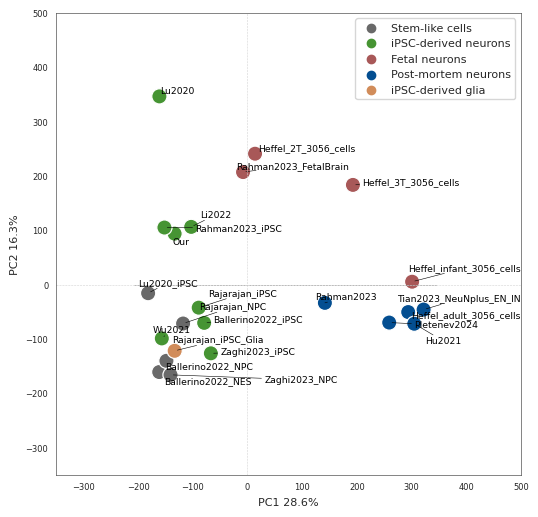

               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


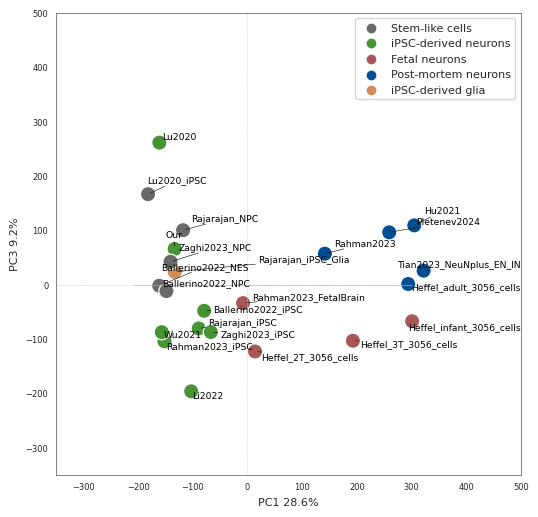

               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


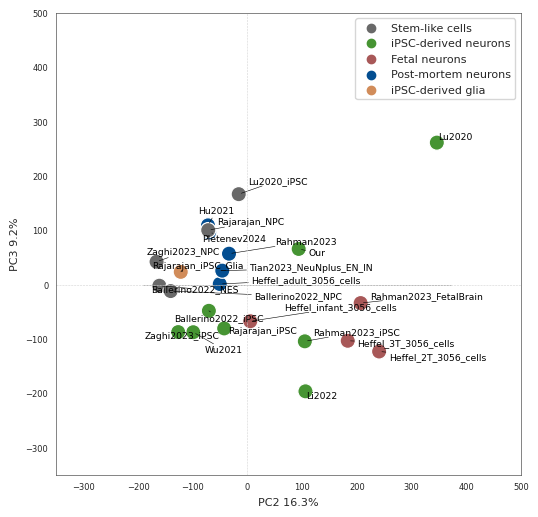

In [59]:
for pca_sel in [['PC1','PC2'], ['PC1','PC3'],['PC2','PC3']]:
    plot_pca(pca, components_df, pca_sel, path_to_save_visualizations, hue ="group", min_v=-350, max_v = 500, save_name=None)